# Deep Learning and Neural Network - Question 2
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

![University of Tehran logo](..\UTLogo\University_of_Tehran_logo.svg "University of Tehran")
![Engineering faculty of University of Tehran logo](..\UTLogo\Engineering_faculty_University_of_Tehran_logo.png "Engineering faculty")

# Outline
- [ 0 - Packages ](#0)
- [ 1 - MLP Design ](#1)
- [ 2 - Two Different Model Training ](#2)
- [ 3 - Backpropagation Algorithm ](#3)
- [ 4 - Different Hyperparameters Checking ](#4)

---

<a name="0"></a>
## 0 - Packages 

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [scikit-learn](https://scikit-learn.org) is a Python module for machine learning.
- [keras_tuner](https://keras.io/keras_tuner)  is an easy-to-use, scalable hyperparameter optimization framework.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2, EfficientNetB6, NASNetMobile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import albumentations as A

from dataset_to_numpy import *
from show_random_images import *
from model_transfer_learning import *
from image_augmentation import *
from accuracy_loss_plot import *

---

<a name="1"></a>
## 1 - Data Preprocessing

In [2]:
dataset_path = "bean-leaf-dataset\\versions\\1"

In [3]:
img_size = (224, 224, 3)
batch_size = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f'{dataset_path}/train/train',
    batch_size=batch_size,
    image_size=img_size[:-1],
    label_mode='int',  # or 'categorical' for one-hot labels
)
validation = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f'{dataset_path}/validation/validation',
    image_size=img_size[:-1],
    batch_size=batch_size,
    label_mode='int',
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f'{dataset_path}/test/test',
    image_size=img_size[:-1],
    batch_size=batch_size,
    label_mode='int',
)
class_names = test.class_names

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [4]:
X_train, y_train = dataset_to_numpy(train)
X_val, y_val = dataset_to_numpy(validation)
X_test, y_test = dataset_to_numpy(test)

In [5]:
print(f'Classes in oreder (0 to 2): {class_names}\n')
print(f'X_train shape: {X_train.shape}\ny_train shape: {X_train.shape}\n')
print(f'X_validation shape: {X_val.shape}\ny_validation shape: {y_val.shape}\n')
print(f'X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

Classes in oreder (0 to 2): ['angular_leaf_spot', 'bean_rust', 'healthy']

X_train shape: (1034, 224, 224, 3)
y_train shape: (1034, 224, 224, 3)

X_validation shape: (133, 224, 224, 3)
y_validation shape: (133,)

X_test shape: (128, 224, 224, 3)
y_test shape: (128,)


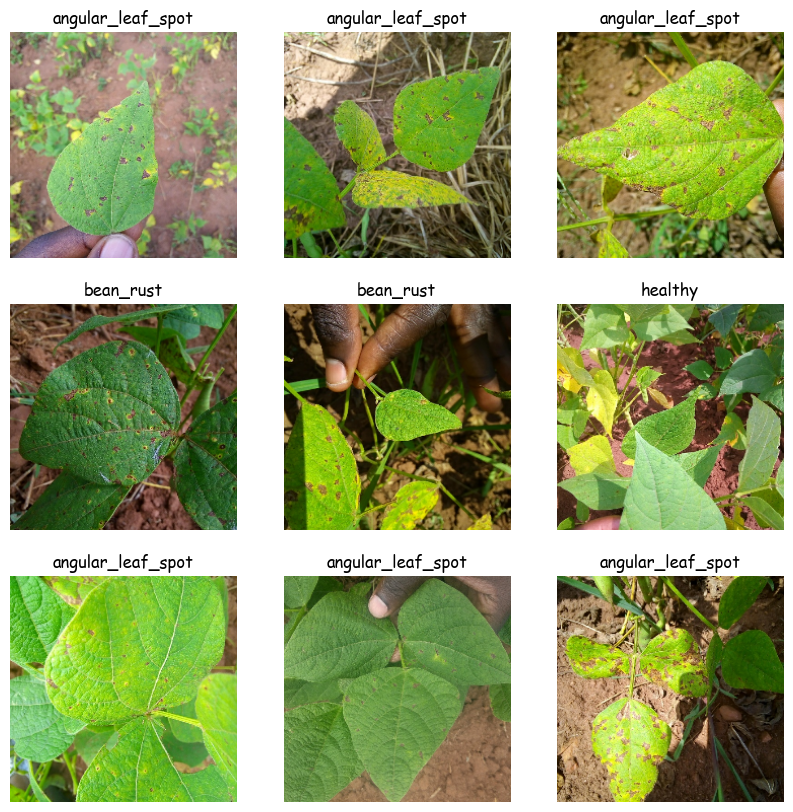

In [6]:
show_random_images(X_train, y_train, class_names, num_images=9)

**<span style="color:red">Note: <span style="color:black">After checking pictures, I find that 1 picture in healty class is missing (according to paper numbers)</span>**

**<span style="color:red"> To Be Completed </span>**

---

<a name="2"></a>
## 2 - Implementatioin

### 2.1 - Model selecting

#### ◆ MobileNetV2

In [7]:
mobileNetV2 = MobileNetV2(include_top=False, input_shape=img_size, weights='imagenet')
mobileNetV2.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

#### ◆ EfficientNetB6

In [8]:
efficientNetB6 = EfficientNetB6(include_top=False, input_shape=img_size, weights='imagenet')
efficientNetB6.summary()

Model: "efficientnetb6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 56)      │           1,512 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 56)      │             224 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 56)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 56)      │             504 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 56)      │             224 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 56)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 56)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 56)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 14)          │             798 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 56)          │             840 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 40,960,143 (156.25 MB)

 Trainable params: 40,735,704 (155.39 MB)

 Non-trainable params: 224,439 (876.72 KB)

#### ◆ NasNet

In [9]:
nasNet = NASNetMobile(include_top=False, input_shape=img_size, weights='imagenet')
nasNet.summary()

Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv1 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn1 (BatchNormalization) │ (None, 111, 111, 32)      │             128 │ stem_conv1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_conv_1_stem_1       │ (None, 111, 111, 11)      │             352 │ activation[0][0]           │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_bn_1_stem_1         │ (None, 111, 111, 11)      │              44 │ reduction_conv_1_stem_1[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 111, 111, 11)      │               0 │ reduction_bn_1_stem_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 115, 115, 11)      │               0 │ activation_1[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 117, 117, 32)      │               0 │ activation_3[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_l… │ (None, 56, 56, 11)        │             396 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_r… │ (None, 56, 56, 11)        │           1,920 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              44 │ separable_conv_1_reductio… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              4

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

### 2.2 - Data Augmentation

In [10]:
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.CLAHE(p=0.2),
])

In [11]:
num_augmentations = 1
X_train, y_train = image_augmentation(X_train, y_train, transform, num_augmentations=num_augmentations)
X_val, y_val = image_augmentation(X_val, y_val, transform, num_augmentations=num_augmentations)
X_test, y_test = image_augmentation(X_test, y_test, transform, num_augmentations=num_augmentations)

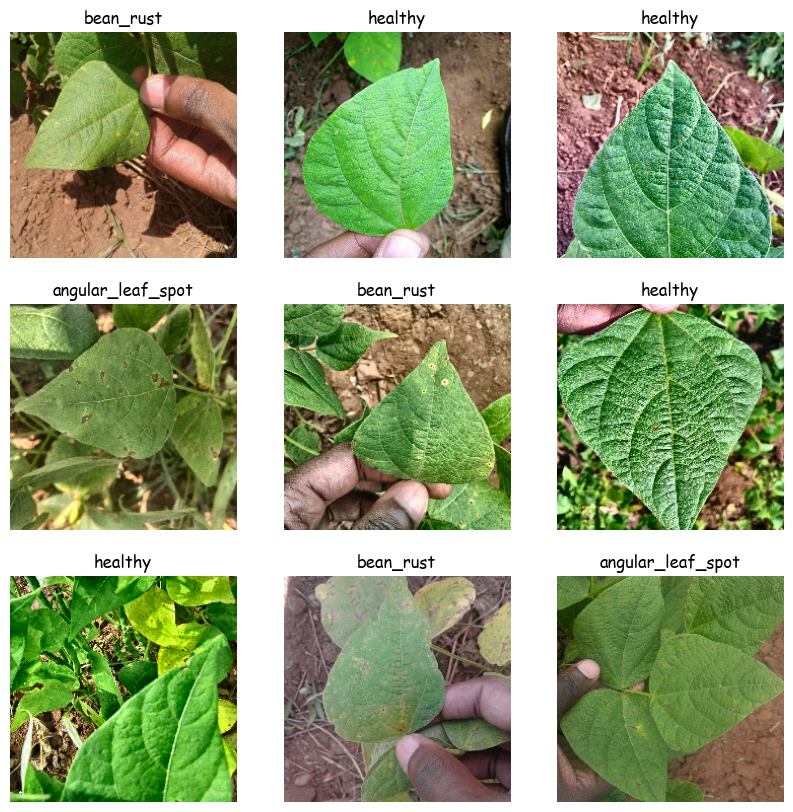

In [12]:
show_random_images(X_train, y_train, class_names, num_images=9)

### 2.3 - Data Augmentation

In [13]:
learning_rate = 0.001
batch_size = 32
epoches = 25
dropout_rate = 0.3
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min',
    restore_best_weights=True
)

In [14]:
mobileNetV2 = model_transfer_learning(mobileNetV2, dropout_rate=dropout_rate)
efficientNetB6 = model_transfer_learning(efficientNetB6, dropout_rate=dropout_rate)
nasNet = model_transfer_learning(nasNet, dropout_rate=dropout_rate)

In [15]:
initial_weightsMobileNetV2 = mobileNetV2.get_weights()
initial_weightsEfficientNetB6 = efficientNetB6.get_weights()
initial_weightsNasNet = nasNet.get_weights()

### 2.4, 2.5 - Optimizers and Model Training

#### ◆ MobileNet

In [16]:
X_train = (X_train / 255).astype(np.float32)
X_val = (X_val / 255).astype(np.float32)
X_test = (X_test / 255).astype(np.float32)

##### Adam Optimizer

In [17]:
mobileNetV2.set_weights(initial_weightsMobileNetV2)
mobileNetV2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
histAdamMobileNetV2 = mobileNetV2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 748ms/step - accuracy: 0.5756 - loss: 1.1086 - val_accuracy: 0.8797 - val_loss: 0.2914
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 743ms/step - accuracy: 0.8222 - loss: 0.4350 - val_accuracy: 0.8947 - val_loss: 0.3229
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 695ms/step - accuracy: 0.7844 - loss: 0.4733 - val_accuracy: 0.8947 - val_loss: 0.2606
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 672ms/step - accuracy: 0.8684 - loss: 0.3014 - val_accuracy: 0.9248 - val_loss: 0.1942
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 753ms/step - accuracy: 0.9086 - loss: 0.2365 - val_accuracy: 0.9173 - val_loss: 0.1920
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 729ms/step - accuracy: 0.9110 - loss: 0.2288 - val_accuracy: 0.9248 - val_loss: 0.1714
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - accuracy: 0.9272 - loss: 0.1952 - val_accuracy: 0.9098 - val_loss: 0.2151
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step - accuracy: 0.9195 - loss: 0.2131 - val_accu

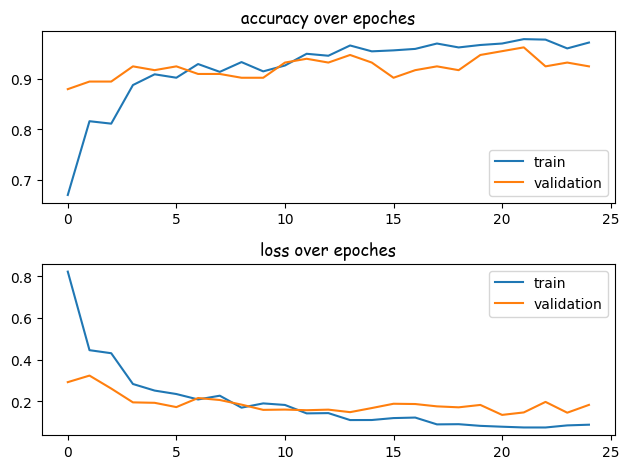

In [18]:
accuracy_loss_plot(histAdamMobileNetV2)

##### Nadam Optimizer

In [19]:
mobileNetV2.set_weights(initial_weightsMobileNetV2)
mobileNetV2.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
histNadamMobileNetV2 = mobileNetV2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 717ms/step - accuracy: 0.5416 - loss: 1.1356 - val_accuracy: 0.8571 - val_loss: 0.3585
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 670ms/step - accuracy: 0.8464 - loss: 0.4299 - val_accuracy: 0.9023 - val_loss: 0.2829
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 696ms/step - accuracy: 0.8792 - loss: 0.3694 - val_accuracy: 0.8872 - val_loss: 0.3143
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - accuracy: 0.8949 - loss: 0.2874 - val_accuracy: 0.8872 - val_loss: 0.2654
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 748ms/step - accuracy: 0.8988 - loss: 0.2416 - val_accuracy: 0.9248 - val_loss: 0.2252
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step - accuracy: 0.9083 - loss: 0.2546 - val_accuracy: 0.9248 - val_loss: 0.1703
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 677ms/step - accuracy: 0.9086 - loss: 0.2299 - val_accuracy: 0.9023 - val_loss: 0.1912


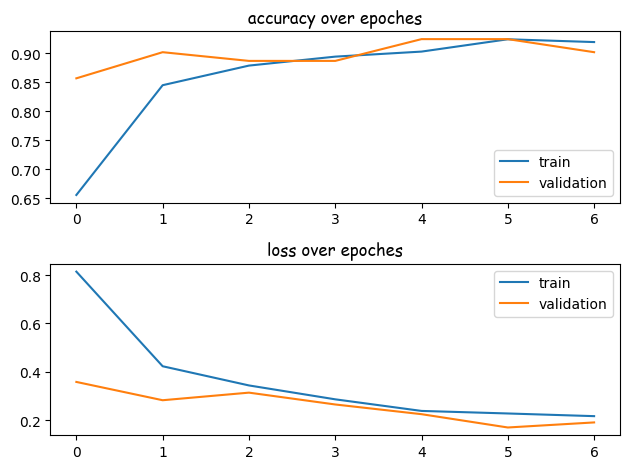

In [20]:
accuracy_loss_plot(histNadamMobileNetV2)

##### RMSprop Optimizer

In [21]:
mobileNetV2.set_weights(initial_weightsMobileNetV2)
mobileNetV2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
histRMSpropMobileNetV2 = mobileNetV2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 716ms/step - accuracy: 0.5316 - loss: 1.9169 - val_accuracy: 0.7519 - val_loss: 0.5373
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 703ms/step - accuracy: 0.8032 - loss: 0.5077 - val_accuracy: 0.7895 - val_loss: 0.4732
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 684ms/step - accuracy: 0.8022 - loss: 0.4325 - val_accuracy: 0.8045 - val_loss: 0.4463
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - accuracy: 0.8502 - loss: 0.3373 - val_accuracy: 0.9173 - val_loss: 0.2166
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - accuracy: 0.8792 - loss: 0.3215 - val_accuracy: 0.9098 - val_loss: 0.2206
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 687ms/step - accuracy: 0.8861 - loss: 0.2884 - val_accuracy: 0.8571 - val_loss: 0.3212
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 745ms/step - accuracy: 0.8852 - loss: 0.2746 - val_accuracy: 0.9023 - val_loss: 0.2322


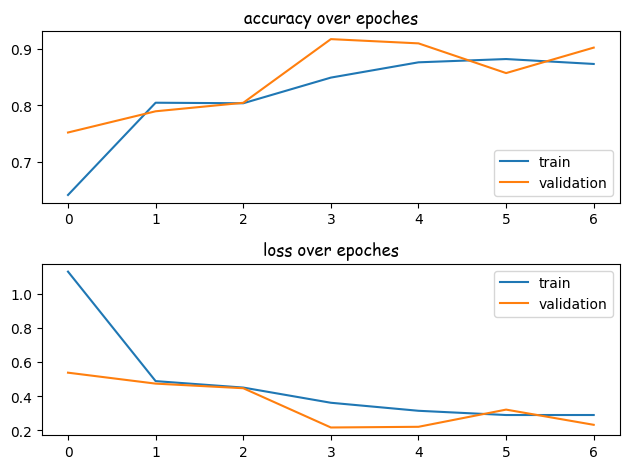

In [22]:
accuracy_loss_plot(histRMSpropMobileNetV2)

#### ◆ EfficientNetB6

In [23]:
X_train = (X_train * 255).astype(np.uint8)
X_val = (X_val * 255).astype(np.uint8)
X_test = (X_test * 255).astype(np.uint8)

##### Adam Optimizer

In [24]:
efficientNetB6.set_weights(initial_weightsEfficientNetB6)
efficientNetB6.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
histAdamEfficientNetB6 = efficientNetB6.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - accuracy: 0.5846 - loss: 0.8201 - val_accuracy: 0.8271 - val_loss: 0.4256
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7987 - loss: 0.4653 - val_accuracy: 0.7970 - val_loss: 0.4690
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8489 - loss: 0.3992 - val_accuracy: 0.8872 - val_loss: 0.3190
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8641 - loss: 0.3143 - val_accuracy: 0.8797 - val_loss: 0.3051
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8576 - loss: 0.3104 - val_accuracy: 0.8872 - val_loss: 0.2731
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9040 - loss: 0.2826 - val_accuracy: 0.9098 - val_loss: 0.2725
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9062 - loss: 0.2322 - val_accuracy: 0.9023 - val_loss: 0.2571


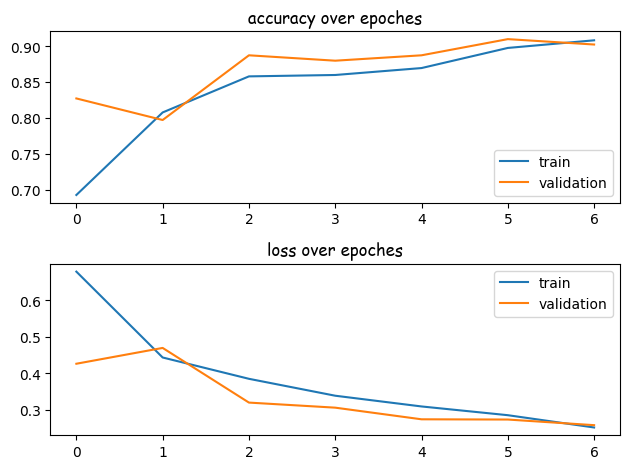

In [25]:
accuracy_loss_plot(histAdamEfficientNetB6)

##### Nadam Optimizer

In [26]:
efficientNetB6.set_weights(initial_weightsEfficientNetB6)
efficientNetB6.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
histNadamEfficientNetB6 = efficientNetB6.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - accuracy: 0.6202 - loss: 0.8380 - val_accuracy: 0.7970 - val_loss: 0.4310
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8456 - loss: 0.4000 - val_accuracy: 0.8947 - val_loss: 0.3081
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8478 - loss: 0.3631 - val_accuracy: 0.8797 - val_loss: 0.2805
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8903 - loss: 0.3094 - val_accuracy: 0.9023 - val_loss: 0.2686
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8724 - loss: 0.3052 - val_accuracy: 0.9023 - val_loss: 0.2627
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8945 - loss: 0.2641 - val_accuracy: 0.9023 - val_loss: 0.2575
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9177 - loss: 0.2334 - val_accuracy: 0.9323 - val_loss: 0.2504


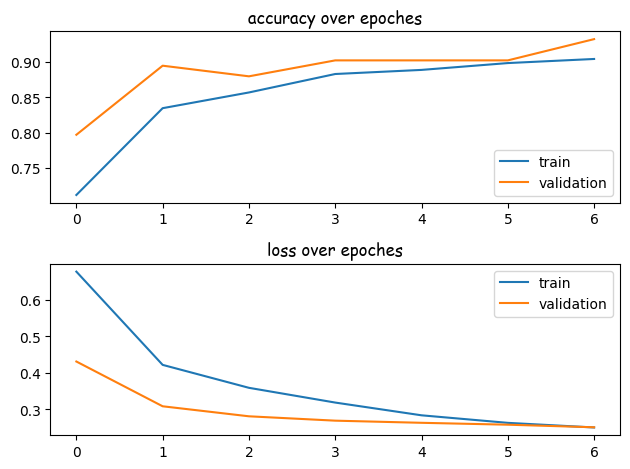

In [27]:
accuracy_loss_plot(histNadamEfficientNetB6)

##### RMSprop Optimizer

In [28]:
efficientNetB6.set_weights(initial_weightsEfficientNetB6)
efficientNetB6.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
histRMSpropEfficientNetB6 = efficientNetB6.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5700 - loss: 0.8741 - val_accuracy: 0.7594 - val_loss: 0.5562
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.7707 - loss: 0.5086 - val_accuracy: 0.7368 - val_loss: 0.6500
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8039 - loss: 0.4489 - val_accuracy: 0.8195 - val_loss: 0.4133
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.8509 - loss: 0.3928 - val_accuracy: 0.8421 - val_loss: 0.3823
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.8548 - loss: 0.3243 - val_accuracy: 0.8872 - val_loss: 0.2935
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8972 - loss: 0.2858 - val_accuracy: 0.8722 - val_loss: 0.3798
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.8847 - loss: 0.2860 - val_accuracy: 0.8872 - val_loss: 0.2948


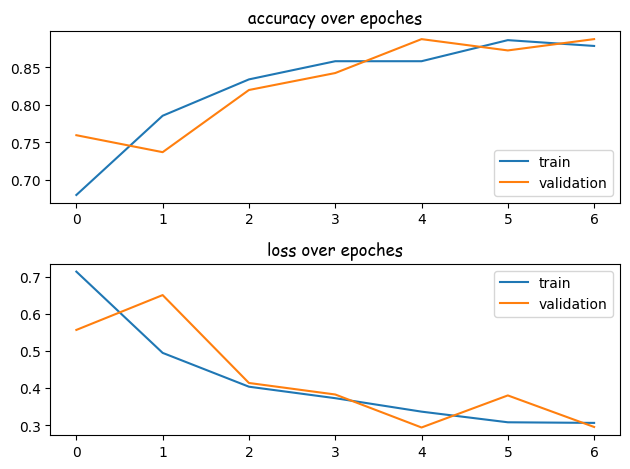

In [29]:
accuracy_loss_plot(histRMSpropEfficientNetB6)

#### ◆ NasNet

In [30]:
X_train = (X_train / 255).astype(np.float32)
X_val = (X_val / 255).astype(np.float32)
X_test = (X_test / 255).astype(np.float32)

##### Adam Optimizer

In [31]:
nasNet.set_weights(initial_weightsNasNet)
nasNet.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
histAdamNasNet = nasNet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 1000ms/step - accuracy: 0.5748 - loss: 1.0059 - val_accuracy: 0.7744 - val_loss: 0.5452
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 785ms/step - accuracy: 0.7245 - loss: 0.6532 - val_accuracy: 0.7895 - val_loss: 0.5265
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 832ms/step - accuracy: 0.7861 - loss: 0.5097 - val_accuracy: 0.8496 - val_loss: 0.4610
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 847ms/step - accuracy: 0.7895 - loss: 0.4955 - val_accuracy: 0.8722 - val_loss: 0.3842
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 817ms/step - accuracy: 0.8095 - loss: 0.4639 - val_accuracy: 0.8872 - val_loss: 0.3589
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 791ms/step - accuracy: 0.8381 - loss: 0.3977 - val_accuracy: 0.8872 - val_loss: 0.3459
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 782ms/step - accuracy: 0.8226 - loss: 0.4057 - val_accuracy: 0.9023 - val_loss: 0.3287


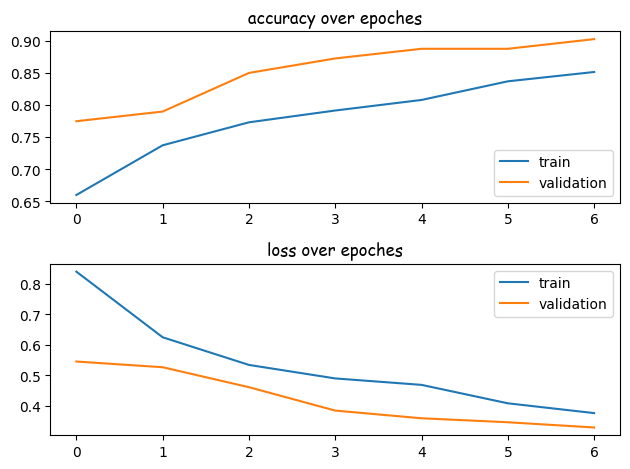

In [32]:
accuracy_loss_plot(histAdamNasNet)

##### Nadam Optimizer

In [33]:
nasNet.set_weights(initial_weightsNasNet)
nasNet.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
histNadamNasNet = nasNet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5227 - loss: 1.0408 - val_accuracy: 0.8271 - val_loss: 0.5575
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 784ms/step - accuracy: 0.7405 - loss: 0.6342 - val_accuracy: 0.8496 - val_loss: 0.4894
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 780ms/step - accuracy: 0.7776 - loss: 0.5304 - val_accuracy: 0.9023 - val_loss: 0.4130
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 779ms/step - accuracy: 0.8033 - loss: 0.4961 - val_accuracy: 0.8722 - val_loss: 0.3887
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 796ms/step - accuracy: 0.8174 - loss: 0.4481 - val_accuracy: 0.8872 - val_loss: 0.3686
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 789ms/step - accuracy: 0.8386 - loss: 0.3906 - val_accuracy: 0.8722 - val_loss: 0.3565
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 786ms/step - accuracy: 0.8727 - loss: 0.3498 - val_accuracy: 0.9098 - val_loss: 0.3314


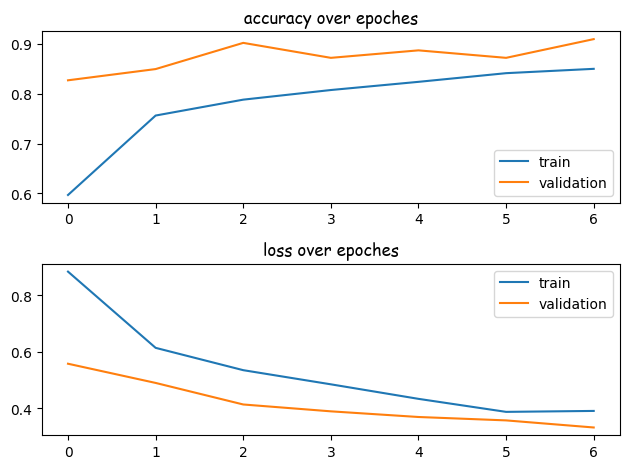

In [34]:
accuracy_loss_plot(histNadamNasNet)

##### RMSprop Optimizer

In [35]:
nasNet.set_weights(initial_weightsNasNet)
nasNet.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
histRMSpropNasNet = nasNet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoches, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 971ms/step - accuracy: 0.5258 - loss: 1.2335 - val_accuracy: 0.7293 - val_loss: 0.6747
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 778ms/step - accuracy: 0.7151 - loss: 0.6941 - val_accuracy: 0.6090 - val_loss: 1.0058
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 785ms/step - accuracy: 0.7336 - loss: 0.6641 - val_accuracy: 0.8195 - val_loss: 0.4847
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 782ms/step - accuracy: 0.7947 - loss: 0.5391 - val_accuracy: 0.7970 - val_loss: 0.5066
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 837ms/step - accuracy: 0.8013 - loss: 0.5126 - val_accuracy: 0.8647 - val_loss: 0.3581
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 848ms/step - accuracy: 0.7952 - loss: 0.5025 - val_accuracy: 0.7820 - val_loss: 0.6171
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 805ms/step - accuracy: 0.8092 - loss: 0.4455 - val_accuracy: 0.8647 - val_loss: 0.4032


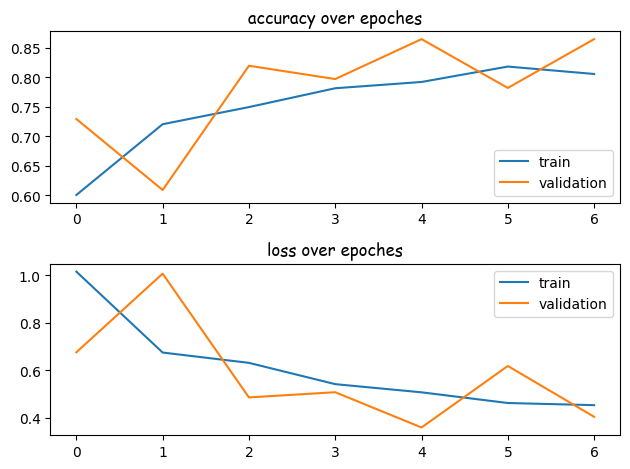

In [36]:
accuracy_loss_plot(histRMSpropNasNet)

---

<a name="3"></a>
## 3 - Results Analysis

---